In [2]:
import sim
%pylab inline
plt.style.use('dark_background')
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['animation.embed_limit'] = 2**128

Populating the interactive namespace from numpy and matplotlib


### Check if python is connecting to Coppelia

In [17]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Pioneer_p3dx'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print('Pioneer_p3dx is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')


Connected
Simulation time in milliseconds:  1587965
Pioneer_p3dx is at [x,y,z]= [7.644186496734619, 8.843599319458008, 0.14069053530693054]
Disconnected


# Robot

In [18]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
    
    def get_orientation(self):
        res, ori = sim.simxGetObjectOrientation(self.client_id, self.frame, -1, sim.simx_opmode_blocking)
        if res != 0:
            print(res, ori)
            return self.get_orientation()
        return ori

# Potential functions

In [5]:
# Potential functions
def force_goal(x, y, goal):
    goal_x, goal_y, k_goal = goal
    Fx_goal, Fy_goal = k_goal * (goal_x - x), k_goal *(goal_y - y)
    return Fx_goal, Fy_goal

def force_obstacle(x, y, obstacle):
    (obs_x, obs_y, k_obs) = obstacle
    dist_x, dist_y = x - obs_x, y - obs_y
    dist_obs = np.hypot(dist_x, dist_y)
    # print(dist_x, dist_y, dist_obs)
    Fx_obs = (dist_x / dist_obs) * k_obs / dist_obs ** 3
    Fy_obs = (dist_y / dist_obs) * k_obs / dist_obs ** 3

    return Fx_obs, Fy_obs 

def total_force(x, y, goal, obstacles):
    Fx, Fy = force_goal(x, y, goal)

    for obs in obstacles:
        Fo_x, Fo_y = force_obstacle(x, y, obs)
        Fx += Fo_x
        Fy += Fo_y
    return Fx, Fy

In [6]:
 def plot_vector_field(ax=plt, fmax = 0.6):
    X, Y = np.meshgrid(np.arange(-10, 10, .5), np.arange(-10, 10, .5))

    # Vector field of the forces
    Fx, Fy = total_force(X, Y, goal, obstacles)

    # For visualization
    F_m = np.hypot(Fx, Fy)
    Fx[F_m > fmax], Fy[F_m > fmax] = None, None
    # Plot
    # quiver(X, Y, Fx, Fy,  F_m, color='0.4', scale=None)
    ax.quiver(X, Y, Fx, Fy, color='0.4')
    

    

def simulate(q, goal, obstacles, num_steps=200, delta_time=1.9):
    trajectory = []
    vels = []
    flag = 0
    i = 0
    initial_q = np.copy(q)
    previous_q = np.copy(q)
    while not np.allclose(np.array((q[0], q[1])), np.array((goal[0], goal[1])), 5e-2):
        if flag:
            obstacles.append([q[0], q[1], 0.1])
            return simulate(initial_q, goal, obstacles, num_steps, delta_time)
        
        force = total_force(q[0], q[1], goal, obstacles)
        # Robot velocity follows the force vector
        vel = np.array(force)
        # Integrate
        q += vel * delta_time
            
        if np.allclose(q, previous_q, 1e-10):
            flag = 1
            continue
            
        trajectory.append(np.copy(q))
        vels.append(np.copy(vel))   
        previous_q = np.copy(q)
        i += 1

    
    return np.array(trajectory), np.array(vels), 0.18

# Plot

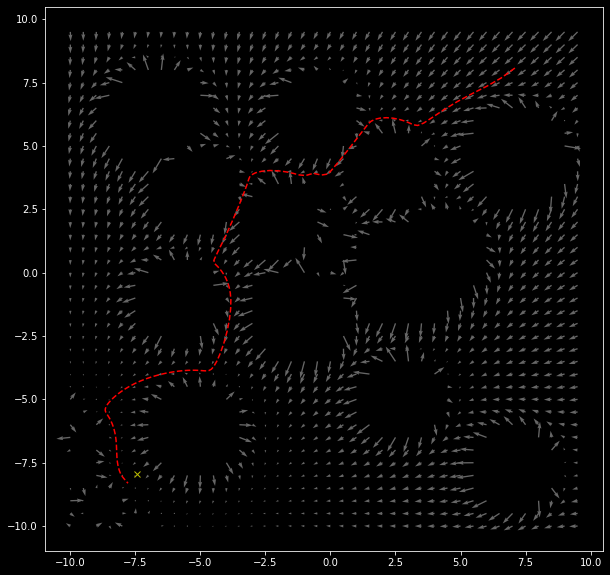

In [7]:
# Goal
goal = [-7.425, -7.925, 0.02]

# Obstacles (x, y, k), where k is the rejection multiplier
r1 = sqrt(square(4) + square(1))/2+1.5
r2 = 1/2 + 1.5

obstacles = [[2.725, -0.00000027, r1],
             [7.425, 4.725, r1],
             [-1.025, -1.5, r1],
             [-6.7, 6.4, r1],
             [-5.15, -6.2, 2.5],
             [2.425, 4.075, r2],
             [4.4, 0.875, r2],
             [2.825, -4.85, r2],
             [-0.525, 6.3, r2],
             [-5.125, 3.425, r2],
             [-1.775, 2.1, r2],
             [-5.8, -0.975, r2],
             [7.275, -7.75, r2]
              ]

# Initial location
q = np.array((7.625, 8.55))

# Show result
trajectory, vels, ti = simulate(q, goal, obstacles)

plot(trajectory[:,0], trajectory[:,1], 'r--')
plot_vector_field()
plot(goal[0], goal[1], 'yx')
# trajectory

# Trajectory follower

In [55]:
# Joint name in coppelia
motor_names = ['Pioneer_p3dx_leftMotor', 'Pioneer_p3dx_rightMotor']
r = robot('Pioneer_p3dx', motor_names)  # Create an instance of our robot
p_traj_point = r.get_position()
p_traj_point = array([p_traj_point[0], p_traj_point[1]])
d = 0.331
r_w = 0.09751

for traj_point, vel_traj in zip(trajectory, vels):
    robot_position = r.get_position()
    robot_position = array([robot_position[0], robot_position[1]])
    u = 10*(traj_point - robot_position) + vel_traj
    vx, vy = u
    v_des = np.hypot(vx, vy)
    ori_r = r.get_orientation()[2]
    ori_d = np.arctan2(vy, vx)
    if ori_d > 0:
        ori_d -= 2 * np.pi
    # print(ori_r * 180 / np.pi, ori_d * 180 / np.pi, p_traj_point, u)
    ori_err = ori_d - ori_r
    print((v_des/10-d*ori_err), (v_des/10+d*ori_err))
    r.send_motor_velocities([(v_des/10-d*ori_err), (v_des/10+d*ori_err)])
    p_traj_point = traj_point
    time.sleep(0.1)

r.send_motor_velocities([0, 0, 0, 0])

r.close_connection()  # End

Robot connected
1.0335463918251584 0.4765216136253594
1.626700668835233 1.1297533368335024
2.109185779555032 1.702343658069819
2.527785192228741 2.1971799976273365
2.8606626493376033 2.597743644853797
3.091257481922641 2.8943278958761187
3.2177198976679966 3.07363413900595
3.2419110306506336 3.1346438110978245
3.099730405753513 3.0059054134030103
2.809675118036663 2.705335982054883
2.6892313924949036 2.561374527569032
2.6348245481472143 2.483185192008204
2.5727747768209257 2.409044644202358
2.5563105923476526 2.3869368243171216
2.5376312350397034 2.3784921252915296
2.542253642461009 2.4000832808763257
2.4724405928247615 2.357550086702033
2.387583620283166 2.3059874481970293
2.192060572161572 2.1539715763109095
1.9633639543109715 1.9711768275209998
1.7852423966460063 1.8399942695563707
1.7441497655917046 1.848272172030086
1.7369778647154948 1.8930425806911262
1.8725589485877319 2.083149104031147
2.2313142799837493 2.4787697226181766
2.60421391639308 2.8491367922428275
2.529124944510407 